In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import tensorflow as tf
# import tensorflow_addons as tfa
import datetime
import pandas as pd

from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import QuantileTransformer, Standardscaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score

c:\users\rared\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
top10_1min_df = pd.read_csv(
    f"../data/1min/top10_2019_train_test.csv.gz",
    sep=',',
    parse_dates=["time"],
    index_col=['time', 'pair'],
    infer_datetime_format=True,
    compression='gzip',
)

In [54]:
top10_1min_df["volume_scaled_5min"].describe()

count    5.255990e+06
mean     8.092131e+02
std      2.348786e+03
min      1.502100e-01
25%      3.667250e+00
50%      5.923150e+01
75%      1.607800e+02
max      1.375800e+04
Name: volume_scaled_5min, dtype: float64

In [5]:
filtered_1min_df = (
    top10_1min_df
    [ top10_1min_df[ f"volume_scaled"].shift(-1) != 0 ]
    .dropna()
)
filtered_1min_df.head()

,,middle_return_1min,volume_scaled,middle_return_5min,volume_scaled_5min,middle_return_10min,volume_scaled_10min,middle_return_20min,volume_scaled_20min,middle_return_40min,volume_scaled_40min,...,volume_scaled_1680min,middle_return_1920min,volume_scaled_1920min,middle_median,future_return_120min_constraint,cross_sectional_median_120min,future_3state_movement_120min_30bps,future_2state_up_movement_120min_30bps,future_2state_down_movement_120min_30bps,future_2state_movement_120min
time,pair,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:01:00,btcusd,-0.000378,0.148808,0.000823,3823.234516,0.000780,3823.400000,0.001416,3820.972565,0.004999,3807.35,...,3940.950000,-0.029168,3941.343073,3826.382003,0.002121,0.001254,0.0,0.0,0.0,1.0
2019-01-01 00:02:00,btcusd,0.000314,0.971417,0.000884,3824.200000,0.001434,3822.100000,0.001574,3821.565333,0.005248,3807.60,...,3942.922533,-0.028964,3941.750000,3827.582003,0.001275,0.001589,0.0,0.0,0.0,-1.0
2019-01-01 00:03:00,btcusd,0.000453,0.854522,0.001325,3824.250000,0.001866,3822.184516,0.002029,3821.565333,0.005638,3807.85,...,3942.922533,-0.029471,3945.600000,3829.317539,0.000300,0.000622,0.0,0.0,0.0,-1.0
2019-01-01 00:04:00,btcusd,0.000922,0.943426,0.001542,3826.950000,0.002786,3822.200000,0.002857,3821.930113,0.006526,3808.00,...,3943.000000,-0.030628,3953.950000,3832.850000,-0.000188,-0.002092,0.0,0.0,0.0,1.0
2019-01-01 00:05:00,btcusd,0.000501,0.422035,0.001814,3827.827600,0.003293,3822.184516,0.002900,3823.681246,0.007043,3807.95,...,3944.800000,-0.030730,3956.350000,3834.769429,0.000375,-0.001656,0.0,0.0,0.0,1.0


In [6]:
x_columns = [ col for col in  top10_1min_df.columns if "return" in col and "future" not in col ]
x_columns_volume = [ col for col in  top10_1min_df.columns if ("return" in col or "volume" in col) and "future" not in col ]
feature_selections = {
    "no_volume": x_columns,
#     "with_volume": x_columns_volume,
}
targets = ["future_2state_movement_120min"]
# ["logistic", "forest", ]

In [7]:
total_size = filtered_1min_df.shape[0]
for volume_desc, columns in feature_selections.items():
    for target in targets:
        print("Target:", target, "Features:", volume_desc)
        # filter out bins for which in the respective next bin no volume was traded and NaN
        # training data from 2019-01-01 to 2019-10-31
#         x_train = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") < "2019-09-15") ][columns]
#         y_train = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") < "2019-09-15") ][target]
#         # training data from 2019-01-01 to 2019-10-31
#         x_validation = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") >= "2019-09-15") & (filtered_1min_df.index.get_level_values("time") < "2019-11-01") ][columns]
#         y_validation = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") >= "2019-09-15") & (filtered_1min_df.index.get_level_values("time") < "2019-11-01") ][target]
        # test data from 2019-11-01 to 2019-12-31
        x_test = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") >= "2019-11-01") ][columns]
        y_test = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") >= "2019-11-01") ][target]
        
        x_train = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") < "2019-11-01") ][columns]
        y_train = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") < "2019-11-01") ][target]        

#         print(
#             "Total Size:", total_size,
#             "| Training Set Size:", x_train.shape[0],
#             "| Validation Set Size:", x_validation.shape[0],
#             "| Test Set Size:", x_test.shape[0]
#         )        

Target: future_2state_movement_120min Features: no_volume


In [8]:
if tf.test.gpu_device_name(): 

    print(f'Default GPU Device:{tf.test.gpu_device_name()}')

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [9]:
def create_model():
    """ Topology: I-H1-H2-H3-O =  """
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=(x_train.shape[1],)),
            tf.keras.layers.Dense(x_train.shape[1],  activation='relu'),
            tf.keras.layers.Dense(x_train.shape[1], activation='relu'),
            tf.keras.layers.Dense(x_train.shape[1], activation='relu'),
            tf.keras.layers.Dense(15, activation='relu'),
            tf.keras.layers.Dense(5, activation='relu'),
            tf.keras.layers.Dense(2, activation='softmax'),
        ]
    )
     
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
# def create_model():
#     # create model
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Dense(12, input_dim=x_train.shape[1], activation='relu'))
#     model.add(tf.keras.layers.Dense(6, activation='relu'))
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#     # Compile model
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [11]:
# def create_model():
#     """ SOURCE: Deep neural networks, gradient-boosted trees,
#         random forests: Statistical arbitrage on the S&P 500 """
    
#     l1_regularizer = tf.keras.regularizers.l1(0.00001)
    
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.Dense(x_train.shape[1], input_dim=x_train.shape[1]),
#         tfa.layers.Maxout(x_train.shape[1], activity_regularizer = l1_regularizer),
#         tf.keras.layers.Dropout(0.5),
        
#         tf.keras.layers.Dense(x_train.shape[1]),
#         tfa.layers.Maxout(x_train.shape[1], activity_regularizer = l1_regularizer),
#         tf.keras.layers.Dropout(0.5),
        
#         tf.keras.layers.Dense(10),
#         tfa.layers.Maxout(10, activity_regularizer = l1_regularizer),
#         tf.keras.layers.Dropout(0.5),
        
#         tf.keras.layers.Dense(5),
#         tfa.layers.Maxout(5, activity_regularizer = l1_regularizer),
#         tf.keras.layers.Dropout(0.5),
        
#         tf.keras.layers.Dense(2, activation='softmax', activity_regularizer = l1_regularizer),
#     ])
#     model.compile(
#         optimizer='adadelta',
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

In [12]:
model = create_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 22)                506       
_________________________________________________________________
dense_1 (Dense)              (None, 22)                506       
_________________________________________________________________
dense_2 (Dense)              (None, 22)                506       
_________________________________________________________________
dense_3 (Dense)              (None, 15)                345       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 12        
Total params: 1,955
Trainable params: 1,955
Non-trainable params: 0
______________________________________________________

In [14]:
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

clf = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=10, epochs=400)


pipeline = Pipeline([
    ('preprocess', QuantileTransformer()),
    ('clf', clf)
])

In [15]:
# patient early stopping
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# save best model with respect to accuracy
# mc = tf.keras.callbacks.ModelCheckpoint('../models/ann/ann_no_volume_future_2state_movement_120min.h5', monitor='val_accuracy', mode='max', save_best_only=True)

pipeline.fit(
    x_train, 
    y_train, 
#           batch_size=512,
#     clf__epochs=400,
#           clf__validation_data=(x_validation, y_validation),
    clf__callbacks=[ tensorboard_callback ],
)
# model.fit(x_train, y_train,)

Epoch 1/400
Epoch 2/400
Epoch 3/400
Epoch 4/400
Epoch 5/400
Epoch 6/400
Epoch 7/400
Epoch 8/400
Epoch 9/400
Epoch 10/400
Epoch 11/400
Epoch 12/400
Epoch 13/400
Epoch 14/400
Epoch 15/400
Epoch 16/400
Epoch 17/400
Epoch 18/400
Epoch 19/400
Epoch 20/400
Epoch 21/400
Epoch 22/400
Epoch 23/400
Epoch 24/400
Epoch 25/400
Epoch 26/400
Epoch 27/400
Epoch 28/400
Epoch 29/400
Epoch 30/400
Epoch 31/400
Epoch 32/400
Epoch 33/400
Epoch 34/400
Epoch 35/400
Epoch 36/400
Epoch 37/400
Epoch 38/400
Epoch 39/400
Epoch 40/400
Epoch 41/400
Epoch 42/400
Epoch 43/400
Epoch 44/400
Epoch 45/400
Epoch 46/400
Epoch 47/400
Epoch 48/400
Epoch 49/400
Epoch 50/400
Epoch 51/400
Epoch 52/400
Epoch 53/400
Epoch 54/400
Epoch 55/400
Epoch 56/400
Epoch 57/400
Epoch 58/400
Epoch 59/400
Epoch 60/400
Epoch 61/400
Epoch 62/400
Epoch 63/400
Epoch 64/400
Epoch 65/400
Epoch 66/400
Epoch 67/400
Epoch 68/400
Epoch 69/400
Epoch 70/400
Epoch 71/400
Epoch 72/400
Epoch 73/400
Epoch 74/400
Epoch 75/400
Epoch 76/400
Epoch 77/400
Epoch 78

Pipeline(memory=None,
         steps=[('preprocess',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('clf',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000270C0C50AC8>)],
         verbose=False)

In [19]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 29608), started 16:08:35 ago. (Use '!kill 29608' to kill it.)

In [18]:
pipeline.model.save("'../models/ann/ann_no_volume_future_2state_movement_120min.h5")

NameError: name 'model_tt' is not defined

In [59]:
pipeline.steps[1][1]

In [17]:
joblib.dump(pipeline, '../models/ann/ann_no_volume_future_2state_movement_120min.pkl')

TypeError: can't pickle _thread.RLock objects

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

In [27]:
predictions = model.predict_classes(x_test)
predictions_proba = model.predict(x_test)

In [33]:
predictions.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [40]:
probabilities_df = pd.DataFrame(probabilities, columns=["down", "up"])
predictions = pd.Series(predictions)

In [47]:
predictions = predictions.map({0: -1, 1: 1})

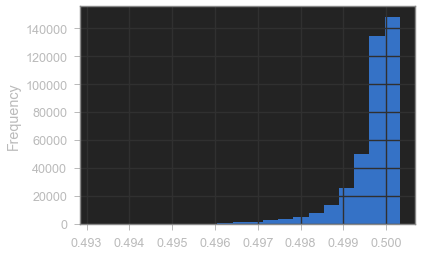

In [49]:
probabilities_df["up"].plot.hist(bins=20)

In [48]:
accuracy_score(y_test, predictions)

0.4962247661438247

In [38]:
y_test.unique()

array([-1.,  1.])